In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from combat.pycombat import pycombat
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE
import joblib
import shap
import lime
import re
shap.initjs()

os.chdir("../../Dataset/Merged")

dataset = pd.read_csv('MergedDataset.csv', index_col=0)

sampleID = dataset['SampleID']
datasetID = dataset['SampleID'].apply(lambda x: x.split('-')[0]).values
indicator = dataset['Label']
dataset = dataset.drop(columns=['SampleID', 'Label'])

dataset = pycombat(dataset.transpose(), datasetID).transpose()

dataset.insert(0, 'SampleID', sampleID)
dataset.insert(1, 'Label', indicator)

def getPatientID(sampleID):
    return sampleID.split('-')[0] + '-' + sampleID.split('-')[1].split('_', 1)[1]

dataset.insert(1, 'PatientID', dataset['SampleID'].apply(getPatientID))
gruppi = dataset.groupby('PatientID')

def sanity_check(gruppi):
    for group_name, group_data in gruppi:
        if 'Control' in group_data['SampleID'].iloc[0]:
            for e in group_data['SampleID']:
                if not 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break
        else:
            for e in group_data['SampleID']:
                if 'Control' in e:
                    print("Errore in gruppo:", group_name)
                    break

sanity_check(gruppi)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state = 42)
split = splitter.split(dataset, groups=dataset['PatientID'])
train_inds, test_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
test = dataset.iloc[test_inds].sample(frac=1, random_state=42)

splitter = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state = 42)
split = splitter.split(train, groups=train['PatientID'])
train_inds, val_inds = next(split)

train = dataset.iloc[train_inds].sample(frac=1, random_state=42)
val = dataset.iloc[val_inds].sample(frac=1, random_state=42)

print("Dataset di train:")
print(train.shape)
print("I malati sono: ", sum(train['Label'] == 1))
print("I sani sono: ", sum(train['Label'] == 0))

print("Dataset di validation:")
print(val.shape)
print("I malati sono: ", sum(val['Label'] == 1))
print("I sani sono: ", sum(val['Label'] == 0))

print("\nDataset di test:")
print(test.shape)
print("I malati sono: ", sum(test['Label'] == 1))
print("I sani sono: ", sum(test['Label'] == 0))

y_train = train['Label']
x_train = train.drop(columns=['SampleID', 'Label', 'PatientID'])

y_val = val['Label']
x_val = val.drop(columns=['SampleID', 'Label', 'PatientID'])

y_test = test['Label']
x_test = test.drop(columns=['SampleID', 'Label', 'PatientID'])

ensemble = joblib.load('../../Modelli/DatasetFull/ensembleSoft.pkl')
shap_values = joblib.load('../../ShapValues/DatasetFull/ensemble_expl.pkl')

Found 7 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Dataset di train:
(1274, 5588)
I malati sono:  748
I sani sono:  526
Dataset di validation:
(319, 5588)
I malati sono:  192
I sani sono:  127

Dataset di test:
(520, 5588)
I malati sono:  245
I sani sono:  275


In [2]:
def createMatrix(limeexplanation, flag=0):
    arr = []
    dict = {}
    regex_pattern = r'\b[A-Za-z_][A-Za-z0-9_-]*\b'

    for feature in x_train.columns:
        dict[feature] = 0

    if flag == 1:
        for exp in limeexplanation:
            for feature, val in exp.as_list():
                match = re.search(regex_pattern, feature)

                #check
                if match[0] not in x_train.columns:
                    print(feature)
                    break

                dict[match[0]] = float(val)
            
            arr.append(list(dict.values()))
            
            dict={}
            for feature in x_train.columns:
                dict[feature] = 0
    else:
        i = 0
        for exp in limeexplanation:
            for label in exp.local_exp.keys():
                for feature, val in exp.as_list(label):
                    match = re.search(regex_pattern, feature)
                #check
                if match[0] not in x_train.columns:
                    print("Errore: ", feature, " mancante")
                    break

                dict[match[0]] = float(val)
            
            arr.append(list(dict.values()))
            
            dict={}
            for feature in x_train.columns:
                dict[feature] = 0

            i=i+1
    return arr

expl = createMatrix(shap_values, 1)

In [3]:
shap_importance = np.abs(expl).mean(0)

In [13]:
print(shap_importance)

[0.00289407 0.00251438 0.00270727 ... 0.00283862 0.0027406  0.00278075]


In [4]:
shapDict = dict(zip(x_train.columns, shap_importance))
sorted_dict = dict(sorted(shapDict.items(), key=lambda x: x[1], reverse=True))
print(sorted_dict)

{'RPL23': 0.03780349553259745, 'HLA-DRB1': 0.027153941970652597, 'ALDOA': 0.02448157608747148, 'GIT2': 0.02282850285783097, 'SKI': 0.021578538865868968, 'ARHGAP4': 0.020819075818859816, 'ZNF223': 0.01771614625297542, 'DDX6': 0.01509705539455005, 'DPYSL2': 0.014063515121155102, 'ASAH1': 0.013174050015911109, 'USP25': 0.01264477833735621, 'DDX3Y': 0.01245196647109851, 'TXNL1': 0.010688668235192423, 'EEF1A1': 0.009882428645552797, 'IL18': 0.009376005674254981, 'HLA-DMB': 0.009210243189847898, 'SEMA4D': 0.009070305088256991, 'HLA-DRB5': 0.008445566173084736, 'ITPR3': 0.008106529145915194, 'UTY': 0.007912932067304214, 'PPT1': 0.007653323470788014, 'ZNF91': 0.007566067025876768, 'RENBP': 0.007155616283859478, 'CNDP2': 0.007038145080116645, 'PITPNM1': 0.0070338684129011755, 'UQCRFS1': 0.0067317385045438955, 'NPR1': 0.006530607193418699, 'CCNT1': 0.0065090839862550105, 'FBLN2': 0.006384572429708247, 'SUMO3': 0.006323692650797608, 'CRNKL1': 0.006021249668463251, 'IL6R': 0.005951652848345167, 'M

In [5]:
old = 0
for i in range(50):
    featureSelected = list(sorted_dict.keys())[:1700+i]
    x_train_splitted = x_train[featureSelected]
    x_val_splitted = x_val[featureSelected]
    ensemble.fit(x_train_splitted, y_train)
    y_pred = ensemble.predict(x_val_splitted)
    score1 = f1_score(y_val, y_pred)
    print(score1-old>0.0000000001)
    old = score1

True


In [ ]:
shap_importance = joblib.load("../../ShapValues/DatasetFull/shap_importance.pkl")

shapDict = dict(zip(shap_values.feature_names, shap_importance))
sorted_dict = dict(sorted(shapDict.items(), key=lambda x: x[1], reverse=True))
print(sorted_dict)

In [ ]:
def featureSelection(model, x_train, y_train, x_val, y_val, shapImportance, featureNames):
    shapDict = dict(zip(featureNames, shapImportance))
    sorted_dict = dict(sorted(shapDict.items(), key=lambda x: x[1], reverse=True))
    result = {}
    saveIdx = 0
    count = 0
    old = 0

    for i in range(5, len(sorted_dict)):
        print(i)
        featureSelected = list(sorted_dict.keys())[:i]
        x_train_splitted = x_train[featureSelected]
        x_val_splitted = x_val[featureSelected]
        model.fit(x_train_splitted, y_train)
        y_pred = model.predict(x_val_splitted)
        score = f1_score(y_val, y_pred)
        result[tuple(featureSelected)] = score

        if i > 1500 and  score - old < 0.0000001:
            count = count + 1 if count == 0 or saveIdx == i - 1 else 1
            saveIdx = i

            if count == 50:
                break

        old = score
    
    return result

featureImportance = featureSelection(ensembleg.best_estimator_, x_train, y_train, x_val, y_val, shap_importance, shap_values.feature_names)

In [ ]:
def featureSelection(model, x_train, y_train, x_val, y_val, shapImportance, featureNames):
    shapDict = dict(zip(featureNames, shapImportance))
    sorted_dict = dict(sorted(shapDict.items(), key=lambda x: x[1], reverse=True))
    result = {}
    saveIdx = 0
    count = 0
    best = 0
    try:
        for i in range(5, len(sorted_dict)):
            featureSelected = list(sorted_dict.keys())[:i]
            x_train_splitted = x_train[featureSelected]
            x_val_splitted = x_val[featureSelected]
            model.fit(x_train_splitted, y_train)
            y_pred = model.predict(x_val_splitted)
            score = f1_score(y_val, y_pred)
            result[tuple(featureSelected)] = score


            print(i)
            print(i, best, score, score-best)

            if i > 4000 and  score - best <= 0:
                count = count + 1

                if count == 100:
                    break
            else: count=0

            if score > best: best = score
    except KeyboardInterrupt:
        joblib.dump(result, "./store/ensemble_featureImportance_interrupted.pkl")
    return result

In [ ]:
featureImportance = joblib.load("../../ShapValues/DatasetFull/feature_importance.pkl")

In [ ]:
sortedFeature = dict(sorted(featureImportance.items(), key=lambda x: x[1], reverse=True))

def prettyPrint(sortedFeature):
    print("Score\tnumFeature\tfeature")
    for i in sortedFeature.keys():
        print(str(sortedFeature[i])+"\t"+str(len(list(i)))+"\t", i)


prettyPrint(sortedFeature)

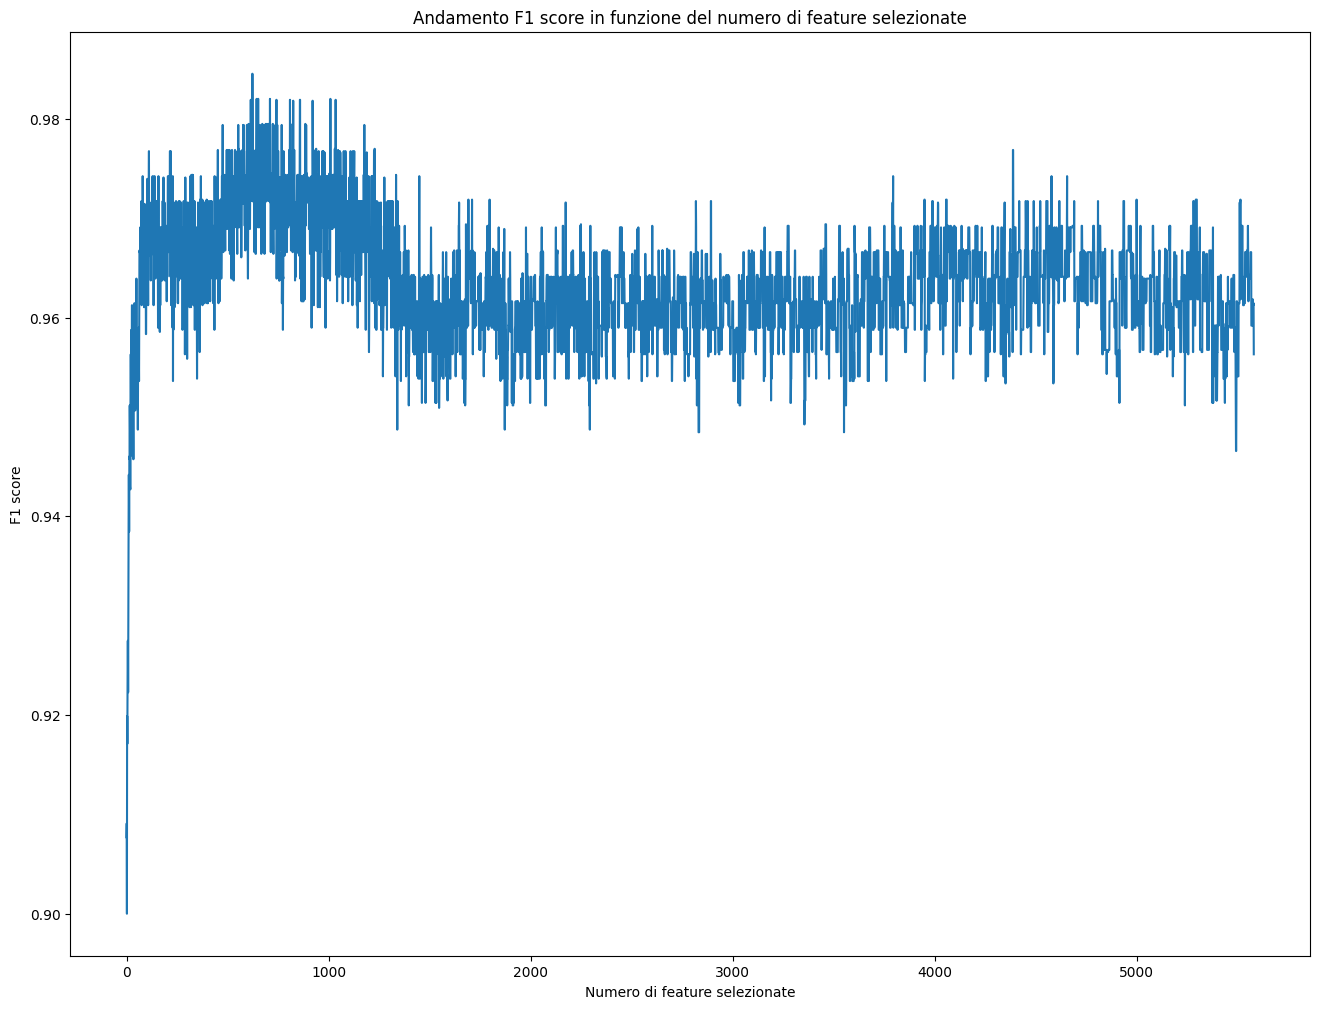

In [20]:
fig, ax = plt.subplots(figsize=(16, 12))

ax.plot(list(featureImportance.values()))
ax.set_title("Andamento F1 score in funzione del numero di feature selezionate")
ax.set_xlabel("Numero di feature selezionate")
ax.set_ylabel("F1 score")
plt.show()